(array([589., 157.,   8.,  10.,  12.,  24.,  32.,  89., 134., 320.]),
 array([   0. ,  235.9,  471.8,  707.7,  943.6, 1179.5, 1415.4, 1651.3,
        1887.2, 2123.1, 2359. ]),
 <a list of 10 Patch objects>)

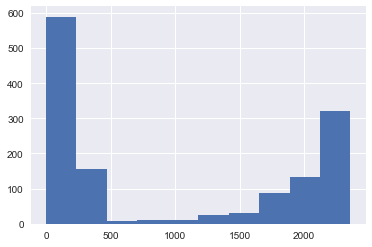

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

data = pd.read_csv('DUI_Citations.csv') #opens data from CSV file

time = np.array(data['Citation Time'])

plt.hist(time)
